<a href="https://colab.research.google.com/github/Joshuajee/AI-ML-PROJECTS/blob/master/Topic%20Modelling%20on%20Financial%20Posts%20from%20Redit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/Joshuajee/AI-ML-PROJECTS/blob/master/Topic Modelling on Financial Posts from Redit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyLDAvis

** **
## Loading the Data
** **
The data was collected manually from twenty two financial subreddit and saved in a csv format to my github repo.

In [13]:
import requests
import numpy as np
import pandas as pd
import re
import os

In [3]:
def get_redit_data_from_github():
  file_path = "https://raw.githubusercontent.com/Joshuajee/AI-ML-PROJECTS/master/data/reddit/reddit_financial_data.csv"
  reponse = requests.get(file_path)
  if reponse.status_code == 200:
    with open("reddit_financial_data.csv", "wb") as f:
      f.write(reponse.content)
    return pd.read_csv("reddit_financial_data.csv", sep=",")
  else:
    raise Exception("Error downloading", reponse.status_code)


In [4]:
reddit_data = get_redit_data_from_github()
reddit_data

,Unnamed: 0,id,subreddit,title,text,url,score,num_comments,created_utc
0,0,1jd5ybv,finance,"Moronic Monday - March 17, 2025 - Your Weekly ...",This is your safe place for questions on finan...,https://www.reddit.com/r/finance/comments/1jd5...,3,20,1.742191e+09
1,1,1jfd4r2,finance,"$1.4bn is a lot to fall through the cracks, ev...",Interesting post on Tesla's accounting (from t...,https://www.ft.com/content/62df8d8d-31f2-445e-...,1206,89,1.742433e+09
2,2,1j7s07n,finance,"Moronic Monday - March 10, 2025 - Your Weekly ...",This is your safe place for questions on finan...,https://www.reddit.com/r/finance/comments/1j7s...,5,21,1.741586e+09
3,3,1j4i8hv,finance,"Goldman, JPMorgan Among Banks Offering More Ru...",The Trump administration isn’t the only one lo...,https://www.bloomberg.com/news/articles/2025-0...,118,10,1.741220e+09
4,4,1j2c1rd,finance,"Moronic Monday - March 03, 2025 - Your Weekly ...",This is your safe place for questions on finan...,https://www.reddit.com/r/finance/comments/1j2c...,3,28,1.740982e+09
...,...,...,...,...,...,...,...,...,...
12870,12870,1ipd9px,dividends,"1,000,000.00 in a schwab money market fund mak...",Super interested in dividend stocks but am a c...,https://www.reddit.com/r/dividends/comments/1i...,161,93,1.739547e+09
12871,12871,1iq6xxy,dividends,New Investor interested in Dividends.,I'm new to investing and just had my first kid...,https://www.reddit.com/r/dividends/comments/1i...,0,10,1.739642e+09
12872,12872,1iq6e30,dividends,Survey for Research-Paper,"Hi \nI’m conducting a survey on the speed, ac...",https://www.reddit.com/r/dividends/comments/1i...,0,1,1.739640e+09
12873,12873,1ipz087,dividends,PBR-A vs. EC,The yields here look very interesting. What is...,https://www.reddit.com/r/dividends/comments/1i...,3,5,1.739617e+09


** **
## Step 2: Data Cleaning
** **

The reddit post data contains multiple columns, but since this is an NLP task only the text and title columns are useful for our Topic modeling task the other columns will be ignored.

1. Join the title and the text columns/
2. Remove punctuations and special characters.




In [5]:
# Join the title and text columns in a new content column
reddit_data['content'] = reddit_data['title'] + ' ' + reddit_data['text']
reddit_data

,Unnamed: 0,id,subreddit,title,text,url,score,num_comments,created_utc,content
0,0,1jd5ybv,finance,"Moronic Monday - March 17, 2025 - Your Weekly ...",This is your safe place for questions on finan...,https://www.reddit.com/r/finance/comments/1jd5...,3,20,1.742191e+09,"Moronic Monday - March 17, 2025 - Your Weekly ..."
1,1,1jfd4r2,finance,"$1.4bn is a lot to fall through the cracks, ev...",Interesting post on Tesla's accounting (from t...,https://www.ft.com/content/62df8d8d-31f2-445e-...,1206,89,1.742433e+09,"$1.4bn is a lot to fall through the cracks, ev..."
2,2,1j7s07n,finance,"Moronic Monday - March 10, 2025 - Your Weekly ...",This is your safe place for questions on finan...,https://www.reddit.com/r/finance/comments/1j7s...,5,21,1.741586e+09,"Moronic Monday - March 10, 2025 - Your Weekly ..."
3,3,1j4i8hv,finance,"Goldman, JPMorgan Among Banks Offering More Ru...",The Trump administration isn’t the only one lo...,https://www.bloomberg.com/news/articles/2025-0...,118,10,1.741220e+09,"Goldman, JPMorgan Among Banks Offering More Ru..."
4,4,1j2c1rd,finance,"Moronic Monday - March 03, 2025 - Your Weekly ...",This is your safe place for questions on finan...,https://www.reddit.com/r/finance/comments/1j2c...,3,28,1.740982e+09,"Moronic Monday - March 03, 2025 - Your Weekly ..."
...,...,...,...,...,...,...,...,...,...,...
12870,12870,1ipd9px,dividends,"1,000,000.00 in a schwab money market fund mak...",Super interested in dividend stocks but am a c...,https://www.reddit.com/r/dividends/comments/1i...,161,93,1.739547e+09,"1,000,000.00 in a schwab money market fund mak..."
12871,12871,1iq6xxy,dividends,New Investor interested in Dividends.,I'm new to investing and just had my first kid...,https://www.reddit.com/r/dividends/comments/1i...,0,10,1.739642e+09,New Investor interested in Dividends. I'm new ...
12872,12872,1iq6e30,dividends,Survey for Research-Paper,"Hi \nI’m conducting a survey on the speed, ac...",https://www.reddit.com/r/dividends/comments/1i...,0,1,1.739640e+09,Survey for Research-Paper Hi \nI’m conducting ...
12873,12873,1ipz087,dividends,PBR-A vs. EC,The yields here look very interesting. What is...,https://www.reddit.com/r/dividends/comments/1i...,3,5,1.739617e+09,PBR-A vs. EC The yields here look very interes...


In [6]:
# Create a new DataFrame containing only the content column
content_df = reddit_data[['content']].copy()
content_df

,content
0,"Moronic Monday - March 17, 2025 - Your Weekly ..."
1,"$1.4bn is a lot to fall through the cracks, ev..."
2,"Moronic Monday - March 10, 2025 - Your Weekly ..."
3,"Goldman, JPMorgan Among Banks Offering More Ru..."
4,"Moronic Monday - March 03, 2025 - Your Weekly ..."
...,...
12870,"1,000,000.00 in a schwab money market fund mak..."
12871,New Investor interested in Dividends. I'm new ...
12872,Survey for Research-Paper Hi \nI’m conducting ...
12873,PBR-A vs. EC The yields here look very interes...


In [7]:
def preprocess(text):
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'[^A-Za-z0-9\s]+', '', text)  # Remove special characters
    text = text.lower()  # Lowercase text
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

In [8]:
# Cleaning the data gotton from reddit as it contains relevant characters
content_df['cleaned_content'] = content_df['content'].apply(preprocess)
content_df

,content,cleaned_content
0,"Moronic Monday - March 17, 2025 - Your Weekly ...",moronic monday march 17 2025 your weekly quest...
1,"$1.4bn is a lot to fall through the cracks, ev...",14bn is a lot to fall through the cracks even ...
2,"Moronic Monday - March 10, 2025 - Your Weekly ...",moronic monday march 10 2025 your weekly quest...
3,"Goldman, JPMorgan Among Banks Offering More Ru...",goldman jpmorgan among banks offering more rus...
4,"Moronic Monday - March 03, 2025 - Your Weekly ...",moronic monday march 03 2025 your weekly quest...
...,...,...
12870,"1,000,000.00 in a schwab money market fund mak...",100000000 in a schwab money market fund making...
12871,New Investor interested in Dividends. I'm new ...,new investor interested in dividends im new to...
12872,Survey for Research-Paper Hi \nI’m conducting ...,survey for researchpaper hi im conducting a su...
12873,PBR-A vs. EC The yields here look very interes...,pbra vs ec the yields here look very interesti...


** **
## Step 3: Exploratory Analysis <a class="anchor\" id="eda"></a>
** **

To verify whether the preprocessing, we’ll make a simple word cloud using the `wordcloud` package to get a visual representation of most common words. It is key to understanding the data and ensuring we are on the right track, and if any more preprocessing is necessary before training the model.



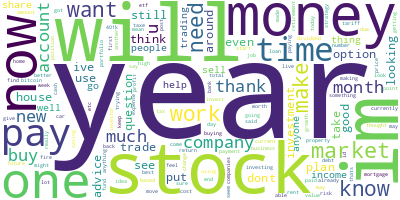

In [9]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(content_df['cleaned_content'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

** **
#### Step 4: Prepare text for LDA analysis <a class="anchor\" id="data_preparation"></a>
** **

Next, let’s work to transform the textual data in a format that will serve as an input for training LDA model. We start by tokenizing the text and removing stopwords. Next, we convert the tokenized object into a corpus and dictionary.

Stop words are a set of commonly used words in a language. Examples of stop words in English are “a”, “the”, “is”, “are” and etc. Stop words are commonly used in Text Mining and Natural Language Processing (NLP) to eliminate words that are so commonly used that they carry very little useful information.

Generate Similar (gensim):
What is Gensim? Gensim = “Generate Similar” is a popular open source natural language processing (NLP) library used for unsupervised topic modeling. It uses top academic models and modern statistical machine learning to perform various complex tasks such as − Building document or word vectors.

NLTK is a toolkit build for working with NLP in Python. It provides us various text processing libraries with a lot of test datasets. A variety of tasks can be performed using NLTK such as tokenizing, parse tree visualization, etc

In [10]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc))
             if word not in stop_words] for doc in texts]


data = content_df.cleaned_content.values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

print(data_words[:1][0][:30])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['moronic', 'monday', 'march', 'weekly', 'questions', 'thread', 'safe', 'place', 'questions', 'financial', 'careers', 'homework', 'problems', 'finance', 'general', 'question', 'finance', 'domain', 'unwelcome', 'replies', 'expected', 'constructive', 'civil', 'questions', 'personal', 'finances', 'belong', 'careerseekers', 'encouraged', 'also']


In [11]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 3), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1)]


** **
#### Step 5: LDA model tranining <a class="anchor\" id="train_model"></a>
** **

To keep things simple, we'll keep all the parameters to default except for inputting the number of topics. For this tutorial, we will build a model with 10 topics where each topic is a combination of keywords, and each keyword contributes a certain weightage to the topic.

In [17]:
from pprint import pprint

# number of topics
num_topics = 5

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.008*"market" + 0.008*"price" + 0.006*"trading" + 0.004*"stock" + '
  '0.004*"trade" + 0.004*"data" + 0.004*"im" + 0.003*"like" + 0.003*"strategy" '
  '+ 0.003*"would"'),
 (1,
  '0.009*"im" + 0.006*"tax" + 0.006*"would" + 0.006*"years" + 0.005*"loan" + '
  '0.005*"year" + 0.004*"time" + 0.004*"get" + 0.004*"like" + 0.004*"anyone"'),
 (2,
  '0.017*"im" + 0.010*"would" + 0.009*"tax" + 0.008*"year" + 0.006*"income" + '
  '0.006*"like" + 0.006*"dividend" + 0.005*"pay" + 0.005*"years" + '
  '0.005*"dividends"'),
 (3,
  '0.013*"im" + 0.012*"dividend" + 0.010*"would" + 0.008*"like" + '
  '0.006*"trading" + 0.006*"know" + 0.006*"stocks" + 0.006*"stock" + '
  '0.005*"dividends" + 0.005*"dont"'),
 (4,
  '0.007*"would" + 0.007*"im" + 0.005*"like" + 0.005*"years" + 0.005*"time" + '
  '0.005*"income" + 0.005*"one" + 0.004*"get" + 0.004*"market" + '
  '0.004*"trading"')]


** **
#### Step 6: Analyzing our LDA model <a class="anchor\" id="results"></a>
** **

Now that we have a trained model let’s visualize the topics for interpretability. To do so, we’ll use a popular visualization package, pyLDAvis which is designed to help interactively with:

1. Better understanding and interpreting individual topics, and
2. Better understanding the relationships between the topics.

For (1), you can manually select each topic to view its top most frequent and/or “relevant” terms, using different values of the λ parameter. This can help when you’re trying to assign a human interpretable name or “meaning” to each topic.

For (2), exploring the Intertopic Distance Plot can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics.

In [ ]:
import pyLDAvis.gensim_models
import pickle
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('/content_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, 'content_'+ str(num_topics) +'.html')

LDAvis_prepared